# Marco Lavorini   -  Assignment 3

In [170]:
import idx2numpy
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from tqdm import tqdm



def read_idx(filename):
    array = idx2numpy.convert_from_file(filename)
    return array

files = ["train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte"]

print(os.path.join("..", "datasets", "mnist", files[0]))
x_train = read_idx(os.path.join("..", "datasets", "mnist", files[0]))
y_train = read_idx(os.path.join("..", "datasets", "mnist", files[1]))
x_test = read_idx(os.path.join("..", "datasets", "mnist", files[2]))
y_test = read_idx(os.path.join("..", "datasets", "mnist", files[3]))

print(y_train)





../datasets/mnist/train-images.idx3-ubyte
[5 0 4 ... 5 6 8]


In [171]:
x_train_b = np.where(x_train > 0, 1, 0)
x_test_b = np.where(x_test > 0, 1, 0)

x_train_b = x_train/255
x_test_b = x_test/255

x_test_flatten = x_test_b.reshape(x_test_b.shape[0], -1)
x_test_flatten.shape



(10000, 784)

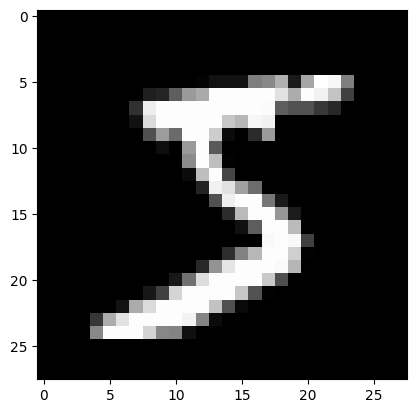

In [172]:
#print first element in data using matplot lib
plt.imshow(x_train_b[0], cmap='gray')
plt.show()

# Sigmoid function

In [173]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [174]:
def mse(net):   
    metric = []
    for i in range(len(x_test_b[0:3000])):
        img = i
        original = x_test_flatten[img]
        recon = net.reconstruct(original).T
        metric.append(mean_squared_error(original, recon))
    return np.mean(metric)


In [175]:

class rbm:
    def __init__(self, num_visible, num_hidden):
        self.h = num_hidden
        self.v = num_visible
        self.W = np.random.uniform(-0.05, 0.05, (num_visible, num_hidden))
        self.bh = np.zeros(num_hidden)
        self.bv = np.zeros(num_visible)
    
    def fit(self, X, epochs=10, lr=0.01, batch_size=10):
        print("todo")
        metric = []

        for epoch in tqdm(range(epochs)):
            err=[]
            for data in X:
                # wake part
                #print('wake')
                pos_def_P = sigmoid(np.dot(data.T, self.W) + self.bh)

                #print(f'pos_def_P shape: {pos_def_P.shape}')
                #print(f'max pos_def_P: {np.max(pos_def_P)}')
                #print(f'max X: {np.max(data)}')
                
                wake = np.dot(data, pos_def_P)
                #print(wake)
                #print(f'\n\n(max wake: {np.max(wake)}\n\n')
            
                #print('dream')
                # dream part
                pos_hid_S = pos_def_P > np.random.rand(self.h) # stochastic hidden activation
                recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

                recon_data = recon_data_P > np.random.rand(self.v)
                neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
                dream = np.dot(recon_data.T, neg_hid_P)
                #print(dream)
                #check
                #err.append(np.sum(data - recon_data)**2)   #check  
            

                deltaW = (wake - dream)
                deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))
                deltaBv = (np.sum(data) - np.sum(recon_data))
                self.W += lr * deltaW
                self.bh += lr * deltaBh
                self.bv += lr * deltaBv
            #print(f'epoch: {epoch}, err: {np.mean(err)}, len err: {len(err)}')
            metric.append(mse(self))
                

    
    def fit_batch(self, data, epochs=10, lr=0.01, batch_size=10):
        print("todo")
        metric = []
        iter = len(data)/batch_size
        print(iter)
        for epoch in tqdm(range(epochs)):
            for i in range(int(iter)):
                X = data[i*batch_size:i*batch_size+ batch_size]
                # wake part
                #print('wake')
                pos_def_P = sigmoid(np.dot(X, self.W) + self.bh)

                #print(f'pos_def_P shape: {pos_def_P.shape}')
                #print(f'max pos_def_P: {np.max(pos_def_P)}')
                #print(f'max X: {np.max(data)}')
                
                wake = np.dot(X.T, pos_def_P)
                #print(wake)
                #print(f'\n\n(max wake: {np.max(wake)}\n\n')
        
                #print('dream')
                # dream part
                pos_hid_S = pos_def_P > np.random.rand(len(pos_def_P), len(pos_def_P[0])) # stochastic hidden activation
                recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

                recon_data = recon_data_P > np.random.rand(len(recon_data_P), len(recon_data_P[0]))
                neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
                dream = np.dot(recon_data.T, neg_hid_P)
                #print(dream)

                #err = (np.sum(X - recon_data)**2)/len(X)   #check  
        

                deltaW = (wake - dream)/len(X)
                deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))/len(X)
                deltaBv = (np.sum(X) - np.sum(recon_data))/len(X)
                self.W += lr * deltaW
                self.bh += lr * deltaBh
                self.bv += lr * deltaBv
        #print(f'epoch: {epoch}, err: {np.mean(err)}, len err: {len(err)}')
            metric.append(mse(self))
        return metric

    def reconstruct(self, X):
        hidden = sigmoid(np.dot(X.T, self.W) + self.bh)
        reconstructed = sigmoid(np.dot(hidden, self.W.T) + self.bv)
        return reconstructed
    
    def hidden(self, X):
        return sigmoid(np.dot(X.T, self.W) + self.bh)
    

# we reshape the data to work with an unidimensional array

In [177]:
print(x_train.shape)
print(x_train[0].shape)
print(x_train[0].flatten().shape)

(60000, 28, 28)
(28, 28)
(784,)


In [179]:
x_train_flattened = x_train_b.reshape(x_train_b.shape[0], -1, 1)
print(x_train_flattened.shape)

(60000, 784, 1)


In [181]:
net = rbm(x_train_flattened.shape[1], 256)
print(f'v = {net.v}')
print(f'h = {net.h}')

v = 784
h = 256


In [182]:
net.fit(x_train_flattened[:1000], epochs=30, lr=0.01, batch_size=500)

todo


100%|██████████| 30/30 [02:25<00:00,  4.85s/it]


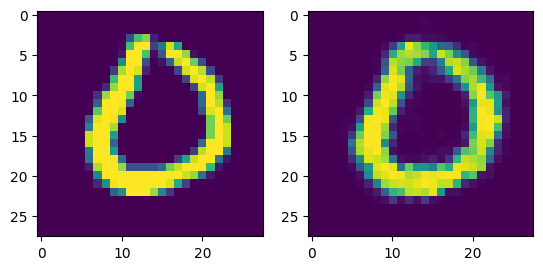

In [183]:

img = 2500
original = x_train_flattened[img]
recon = net.reconstruct(original)
#plot the original by the side
plt.subplot(1, 2, 1)
plt.imshow(x_train[img].reshape(28, 28))
plt.subplot(1, 2, 2)
plt.imshow(recon.reshape(28, 28))

plt.show()

In [185]:
net_batch = rbm(x_train_flattened.shape[1], 256)
print(f'v = {net_batch.v}')
print(f'h = {net_batch.h}')

v = 784
h = 256


In [186]:
x_train_b.shape
x_train_flattened_batch = x_train_b.reshape(x_train_b.shape[0], -1)

In [193]:
losses = net_batch.fit_batch(x_train_flattened_batch[:4000], epochs=50, lr=0.01, batch_size=10)

todo
400.0


100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


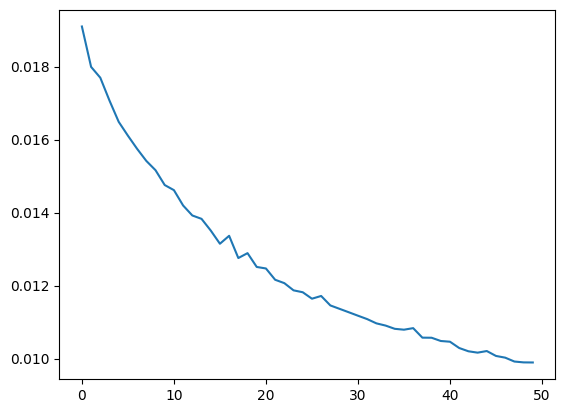

In [194]:
# plot the losses
plt.plot(losses)
plt.show()

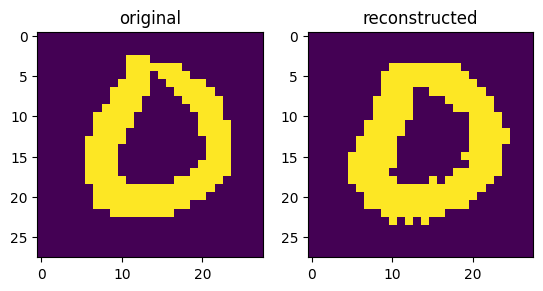

In [196]:
original = x_train_flattened[img]
# threshold the image, 0 if equals to 0 1 otherwhise
original_t = np.where(original > 0.09, 1, 0)
recon_t = np.where(recon > 0.09, 1, 0)
# print the image with matplotlib
plt.subplot(1, 2, 1)
plt.imshow(original_t.reshape(28, 28))
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(recon_t.reshape(28, 28))
plt.title('reconstructed')

plt.show()


In [197]:
print(original_t.shape, recon_t.shape)

(784, 1) (1, 784)


In [198]:
# calculate jaccard similarity
from sklearn.metrics import jaccard_score
jaccard_score(original_t, recon_t.T)


0.8046511627906977

In [202]:
# find the first of each number in the dataset
digits = []
for i in range(10):
    digits.append(np.where(y_train == i)[0][0])
print(digits)

[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]


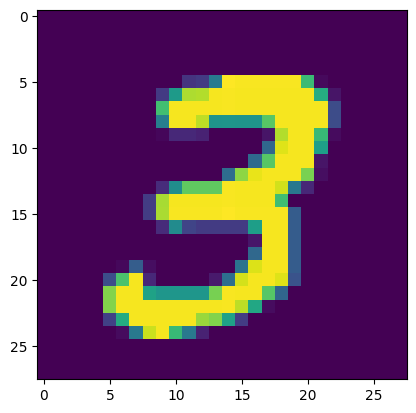

In [209]:
plt.imshow(x_train[digits[3]])

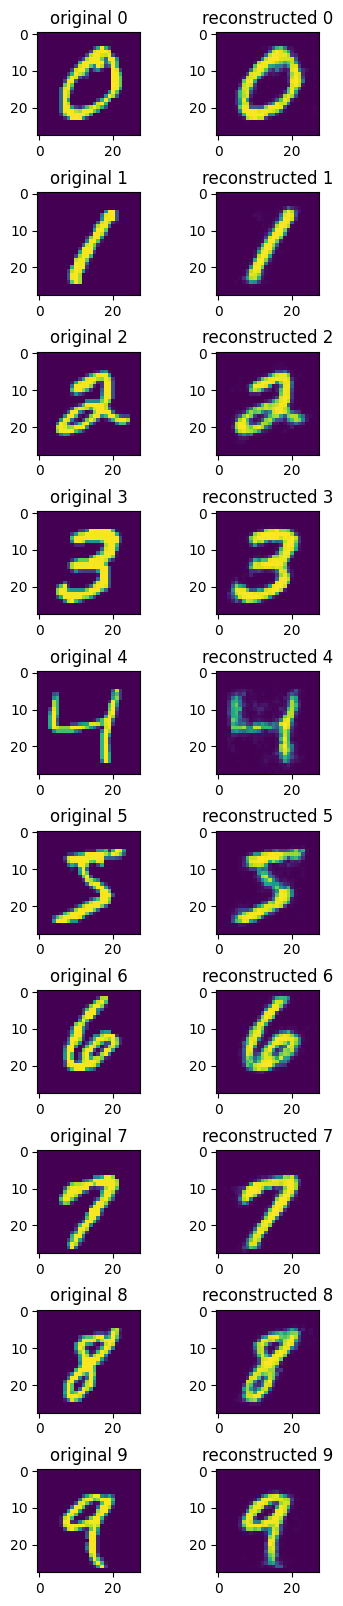

In [218]:
# print a 10x2 grid with the original and reconstructed images of the images with the indexes in digits
plt.figure(figsize=(10, 20))
for i in range(10):
    plt.subplot(10, 2, 2*i+1)
    plt.imshow(x_train[digits[i]])
    plt.title(f'original {y_train[digits[i]]}')
    plt.subplot(10, 2, 2*i+2)
    plt.imshow(net.reconstruct(x_train_flattened[digits[i]]).reshape(28, 28))
    plt.title(f'reconstructed {y_train[digits[i]]}')
plt.subplots_adjust(hspace = 0.55)
plt.subplots_adjust(wspace = -0.7)

In [219]:
metric = []
for i in tqdm(range(len(x_test_b[0:3000]))):
    img = i
    original = x_test_flatten[img]
    recon = net.reconstruct(original).T
    metric.append(mean_squared_error(original, recon))
print(np.mean(metric))

max = metric.index(np.max(metric))
min = metric.index(np.min(metric))

print(max, min)

100%|██████████| 3000/3000 [00:01<00:00, 1506.98it/s]

0.014473291339175904
1017 178


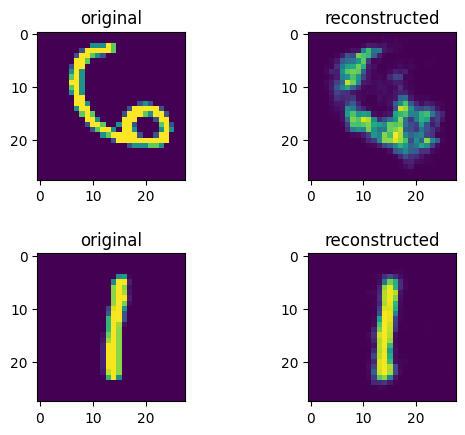

In [220]:
# plot a 2x2 grid with the original and reconstructed images of both min and max mse
plt.subplot(2, 2, 1)
plt.imshow(x_test_flatten[max].reshape(28, 28))
plt.title('original')
plt.subplot(2, 2, 2)
plt.imshow(net.reconstruct(x_test_flatten[max]).reshape(28, 28))
plt.title('reconstructed')
plt.subplot(2, 2, 3)
plt.imshow(x_test_flatten[min].reshape(28, 28))
plt.title('original')
plt.subplot(2, 2, 4)
plt.imshow(net.reconstruct(x_test_flatten[min]).reshape(28, 28))
plt.title('reconstructed')
plt.subplots_adjust(hspace = 0.5)  # Adjust the vertical spacing here

plt.show()


(256,) (784, 256) (784,) (256,)


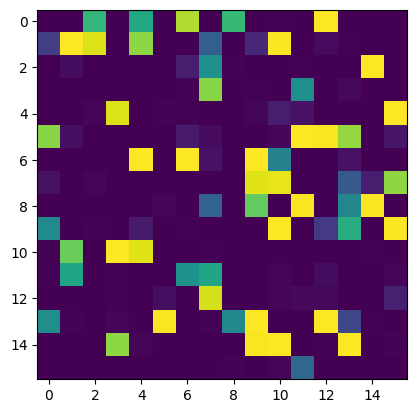

In [226]:
h = net.bh
W = net.W
X = x_test_flatten[0]

hidden = sigmoid(np.dot(X.T, W) + h)

print(h.shape, W.shape, X.shape, hidden.shape)

plt.imshow(hidden.reshape(16,16))


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:02<00:00, 1489.89it/s]


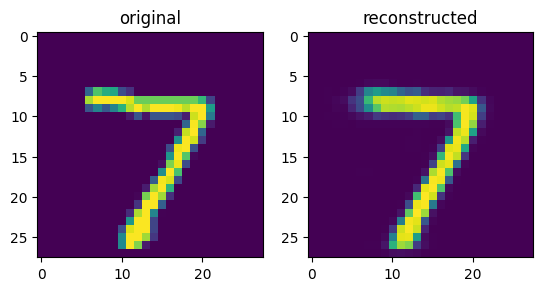

In [147]:
new_X = []
for i in tqdm(range(3000)):
    img = i
    original = x_test_flatten[img]
    recon = net.reconstruct(original).T
    new_X.append(recon)

plt.subplot(1, 2, 1)
plt.imshow(x_test[0])
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(new_X[0].reshape(28, 28))
plt.title('reconstructed')
plt.show()

Iteration 1, loss = 2.11123530
Iteration 2, loss = 1.79659548
Iteration 3, loss = 1.61305537
Iteration 4, loss = 1.46329263
Iteration 5, loss = 1.33106542
Iteration 6, loss = 1.21555680
Iteration 7, loss = 1.10215055
Iteration 8, loss = 0.98718866
Iteration 9, loss = 0.87679619
Iteration 10, loss = 0.77989539
Iteration 11, loss = 0.69212953
Iteration 12, loss = 0.59939630
Iteration 13, loss = 0.52136349
Iteration 14, loss = 0.45412592
Iteration 15, loss = 0.40554632
Iteration 16, loss = 0.36946216
Iteration 17, loss = 0.33977591
Iteration 18, loss = 0.31348823
Iteration 19, loss = 0.29122828
Iteration 20, loss = 0.27395796
Iteration 21, loss = 0.25566554
Iteration 22, loss = 0.24277097
Iteration 23, loss = 0.22545977
Iteration 24, loss = 0.20995360
Iteration 25, loss = 0.20111892
Iteration 26, loss = 0.19180634
Iteration 27, loss = 0.17756420
Iteration 28, loss = 0.16733397
Iteration 29, loss = 0.15720476
Iteration 30, loss = 0.14745102
Iteration 31, loss = 0.14099691
Iteration 32, los

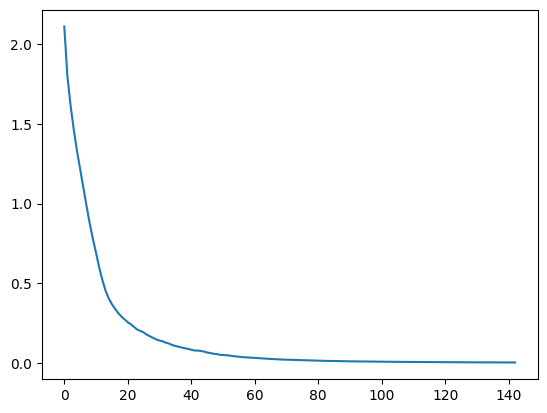

In [155]:
# train a mlp with the reconstructed data and plot the accuracy and loss, during training show the time remaining
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaler.fit(x_train_flattened)
"""x_train_scaled = scaler.transform(x_train_flattened)
x_test_scaled = scaler.transform(x_test_flatten)"""

mlp = MLPClassifier(hidden_layer_sizes=(64, 16, 8), max_iter=1000, verbose=True)
mlp.fit(new_X, y_test[:3000]) # TODO:watch out i worked with the test set before, to fix

y_pred = mlp.predict(x_test_flatten)
accuracy_score(y_test[5000:8000], y_pred[5000:8000])

plt.plot(mlp.loss_curve_)
plt.show()





In [156]:
print(accuracy_score(y_test[:3000], y_pred[:3000]))

0.9653333333333334
